In [1]:
# Cell 1 — Imports & global settings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    silhouette_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

RNG = 42
np.random.seed(RNG)
plt.rcParams.update({"figure.figsize": (6,4), "axes.grid": True})


In [2]:
# Helper functions (metrics & plots)

def evaluate_classifier(y_true, y_pred, model_name: str):
    """Print basic classification metrics and show a confusion matrix."""
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    print(f"\n📊 {model_name} — metrics")
    print(f"Accuracy: {acc:.3f}")
    print(f"F1 (macro): {f1_macro:.3f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {model_name}")
    plt.tight_layout()
    plt.show()


def plot_elbow_kmeans(X, kmin=2, kmax=10, title_prefix=""):
    """Elbow method: SSE (inertia) vs k."""
    inertias = []
    ks = list(range(kmin, kmax+1))
    for k in ks:
        km = KMeans(n_clusters=k, random_state=RNG, n_init=10)
        km.fit(X)
        inertias.append(km.inertia_)
    plt.figure()
    plt.plot(ks, inertias, marker="o")
    plt.xlabel("k")
    plt.ylabel("SSE (inertia)")
    plt.title(f"{title_prefix} Elbow method")
    plt.tight_layout()
    plt.show()


def plot_pca_2d(X, y=None, title="PCA (2D)"):
    pca = PCA(n_components=2, random_state=RNG)
    X2 = pca.fit_transform(X)
    plt.figure()
    if y is None:
        plt.scatter(X2[:,0], X2[:,1], s=18)
    else:
        # color by class/label
        for cls in np.unique(y):
            idx = (y == cls)
            plt.scatter(X2[idx,0], X2[idx,1], s=18, label=str(cls))
        plt.legend(title="Class")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [3]:
USE_DATASET = "breast_cancer"  # or "iris"

if USE_DATASET == "breast_cancer":
    data = load_breast_cancer()
elif USE_DATASET == "iris":
    data = load_iris()
else:
    raise ValueError("Unknown dataset: use 'breast_cancer' or 'iris'.")

X = data.data
y = data.target

Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RNG
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

print(f"Train: {Xtr.shape}, Test: {Xte.shape}")


Train: (455, 30), Test: (114, 30)


Decision Tree

📊 Decision Tree (default) — metrics
Accuracy: 0.912
F1 (macro): 0.907

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        42
           1       0.96      0.90      0.93        72

    accuracy                           0.91       114
   macro avg       0.90      0.92      0.91       114
weighted avg       0.92      0.91      0.91       114



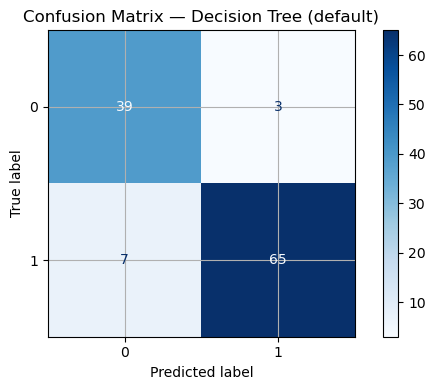

Best DT params: {'max_depth': 3, 'min_samples_split': 5}

📊 Decision Tree (GridSearch) — metrics
Accuracy: 0.939
F1 (macro): 0.934

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        42
           1       0.95      0.96      0.95        72

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



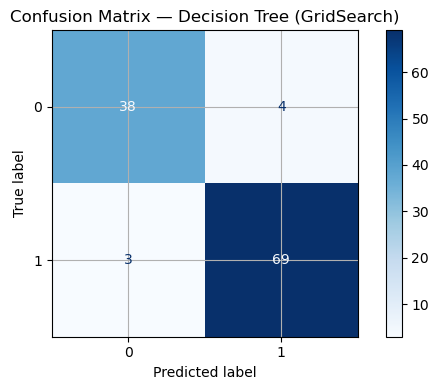

In [4]:
print("Decision Tree")
dt = DecisionTreeClassifier(random_state=RNG)
dt.fit(Xtr, ytr)
yp_dt = dt.predict(Xte)
evaluate_classifier(yte, yp_dt, model_name="Decision Tree (default)")

param_dt = {
    "max_depth": [None, 3, 5, 8, 12],
    "min_samples_split": [2, 5, 10]
}
gs_dt = GridSearchCV(dt, param_grid=param_dt, cv=cv, scoring="f1_macro", n_jobs=-1)
gs_dt.fit(Xtr, ytr)
print(f"Best DT params: {gs_dt.best_params_}")
yp_dt_best = gs_dt.predict(Xte)
evaluate_classifier(yte, yp_dt_best, model_name="Decision Tree (GridSearch)")


k-NN
Best k-NN params: {'knn__n_neighbors': 5, 'knn__weights': 'uniform'}

📊 k-NN (Pipeline + GridSearch) — metrics
Accuracy: 0.956
F1 (macro): 0.953

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



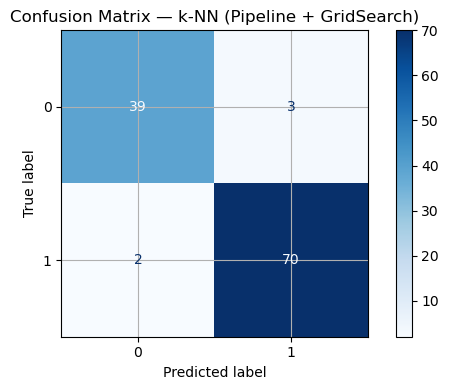

In [5]:
print("k-NN")
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

param_knn = {
    "knn__n_neighbors": [3, 5, 7, 11],
    "knn__weights": ["uniform", "distance"]
}

gs_knn = GridSearchCV(knn_pipe, param_grid=param_knn, cv=cv, scoring="f1_macro", n_jobs=-1)
gs_knn.fit(Xtr, ytr)
print(f"Best k-NN params: {gs_knn.best_params_}")
yp_knn = gs_knn.predict(Xte)
evaluate_classifier(yte, yp_knn, model_name="k-NN (Pipeline + GridSearch)")


Naive Bayes (GaussianNB)

📊 GaussianNB — metrics
Accuracy: 0.939
F1 (macro): 0.934

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        42
           1       0.95      0.96      0.95        72

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



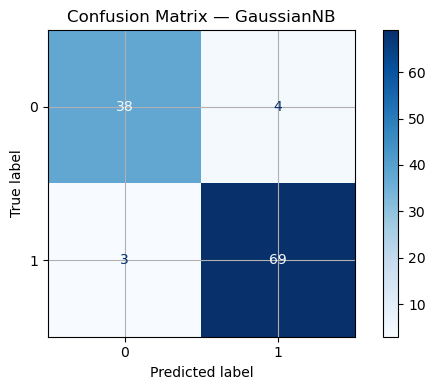

In [6]:
print("Naive Bayes (GaussianNB)")
gnb = GaussianNB()
gnb.fit(Xtr, ytr)
yp_nb = gnb.predict(Xte)
evaluate_classifier(yte, yp_nb, model_name="GaussianNB")

K-Means (Clustering)


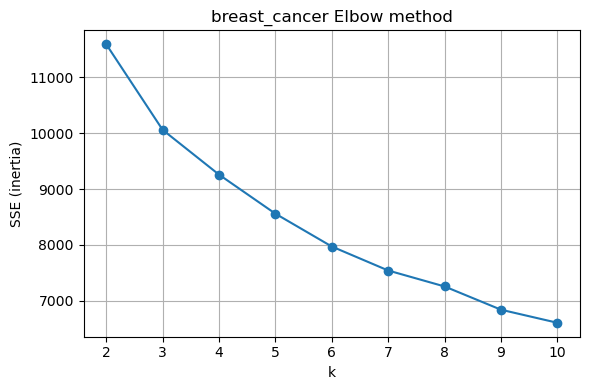

Silhouette score (k=2): 0.343


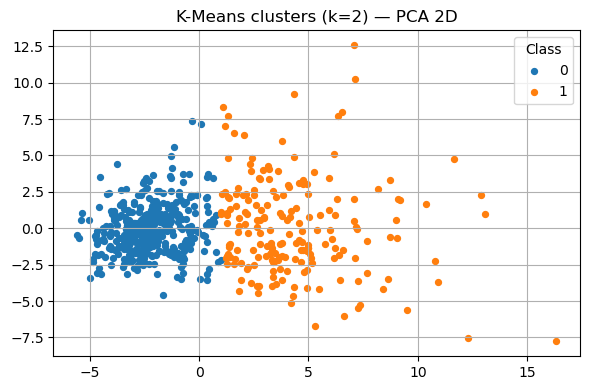

Contingency matrix (class vs cluster): [[ 36 176]
 [339  18]]


In [7]:
# K-Means (clustering, unsupervised)

print("K-Means (Clustering)")

# For clustering we typically scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Elbow plot
plot_elbow_kmeans(X_scaled, kmin=2, kmax=10, title_prefix=USE_DATASET)


# k = number of classes or via elbow/silhouette
k = len(np.unique(y)) if len(np.unique(y)) >= 2 else 3
km = KMeans(n_clusters=k, random_state=RNG, n_init=10)
labels_km = km.fit_predict(X_scaled)


# Silhouette score (when k>=2)
if k >= 2 and len(np.unique(labels_km)) > 1:
    sil = silhouette_score(X_scaled, labels_km)
print(f"Silhouette score (k={k}): {sil:.3f}")


# PCA 2D cluster visualization
plot_pca_2d(X_scaled, labels_km, title=f"K-Means clusters (k={k}) — PCA 2D")


# Compare clusters with ground-truth classes

try:
    from sklearn.metrics.cluster import contingency_matrix
    cont = contingency_matrix(y, labels_km)
    print("Contingency matrix (class vs cluster):", cont)
except Exception as e:
    print("(Skipping contingency_matrix)", e)



In [8]:
print("Association Rules (Apriori)")

# Small transactional toy dataset — each transaction is a set of items
transactions = [
{"milk", "bread", "butter"},
{"milk", "eggs"},
{"bread", "butter"},
{"milk", "bread", "eggs"},
{"butter", "jam"},
{"milk", "bread", "butter", "jam"},
]

# Try mlxtend otherwise print a simple fallback summary
try:
    from mlxtend.frequent_patterns import apriori, association_rules
    from mlxtend.preprocessing import TransactionEncoder

    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_tx = pd.DataFrame(te_ary, columns=te.columns_)

    freq = apriori(df_tx, min_support=0.3, use_colnames=True)
    rules = association_rules(freq, metric="confidence", min_threshold=0.6)

    print("Frequent itemsets:", freq.sort_values("support", ascending=False))
    print("Rules (antecedents => consequents):",
          rules.sort_values("confidence", ascending=False))
except Exception as e:
    print("mlxtend not available — using a simple fallback example")
    
from collections import Counter

item_counts = Counter()
pair_counts = Counter()
n = len(transactions)
for t in transactions:
    item_counts.update(t)
for a in t:
    for b in t:
        if a < b:
            pair_counts.update([(a,b)])
print("Most frequent single items (support):")

for item, cnt in item_counts.most_common():
    print(f" {item}: {cnt/n:.2f}")
    print("Most frequent pairs (rough support):")

for pair, cnt in pair_counts.most_common():
    print(f" {pair}: {cnt/n:.2f}")

Association Rules (Apriori)
mlxtend not available — using a simple fallback example
Most frequent single items (support):
 bread: 0.67
Most frequent pairs (rough support):
 milk: 0.67
Most frequent pairs (rough support):
 butter: 0.67
Most frequent pairs (rough support):
 eggs: 0.33
Most frequent pairs (rough support):
 jam: 0.33
Most frequent pairs (rough support):
 ('bread', 'jam'): 0.17
 ('bread', 'milk'): 0.17
 ('bread', 'butter'): 0.17
 ('jam', 'milk'): 0.17
 ('butter', 'jam'): 0.17
 ('butter', 'milk'): 0.17
